In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error
import time
import json
from lib.llm_utils import *

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'llm_v1_tokens_v2_k3'
DATA_FNAME = 'data/llm/events_test_k3.txt'
K = 3
N_SIMS = 1000

# Organizing data

In [3]:
df = pd.read_csv(DATA_FNAME, sep=' ', header=None, dtype=str)
df = df.fillna('<NaN>')

# Load Model

In [4]:
tokenizer_map, detokenizer_map = get_tokenizer_map(df)
restrictions, offset_restrictions = get_restrictions(K)

In [5]:
model = torch.load(f'models/llm/full_{MODEL_NAME}.pth')
model.eval()

MultiLayerBinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=40, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=139, bias=True)
    (7): Sigmoid()
  )
)

# Metrics

In [6]:
def calculate_error(df, loc, k=1, metrics_type='regression'):
    restrictions, offset_restrictions = get_restrictions(k)

    _df = df.copy()
    _df['target'] = _df[loc]
    for j in range(loc, k*11+7):
        _df[j] = '<NaN>'
    _df = _df[(_df['target'] != '<NaN>') & (_df['target'] != '<GAME_OVER>')]

    df_train_11 = _df.copy()

    for j in range(0, k*11+7):
        _df[j] = _df[j].map(tokenizer_map)

    X_train_11 = _df.drop('target', axis=1).astype(float).values

    pred_11 = model(torch.tensor(X_train_11, dtype=torch.float32).to(DEVICE))
    pred_11 = torch.argmax(pred_11[:, restrictions[loc]], dim=1) + offset_restrictions[loc]
    df_train_11['pred'] = pred_11.cpu().detach().numpy()
    df_train_11['target'] = df_train_11['target'].map(tokenizer_map)
    
    if metrics_type == 'regression':
        return {'MAE': round(mean_absolute_error(df_train_11['target'], df_train_11['pred']), 5), 'R2': round(r2_score(df_train_11['target'], df_train_11['pred']), 5)}
    elif metrics_type == 'classification':
        if len(restrictions[loc]) == 2:
            return {'ACC': round(accuracy_score(df_train_11['target'], df_train_11['pred']), 5), 'F1': round(f1_score(df_train_11['target'], df_train_11['pred']), 5)}
        else:
            return {'ACC': round(accuracy_score(df_train_11['target'], df_train_11['pred']), 5), 'F1': round(f1_score(df_train_11['target'], df_train_11['pred'], average='weighted'), 5)}
    else:
        raise Exception('Unknown metrics type')

In [7]:
pd.DataFrame({
    'Event Type': calculate_error(df, 33, k=K, metrics_type='classification'),
    'Is Goal': calculate_error(df, 34, k=K, metrics_type='classification'),
    'Is Accurate': calculate_error(df, 35, k=K, metrics_type='classification'),
    'Is Home Team': calculate_error(df, 36, k=K, metrics_type='classification'),
    'Time Elapsed': calculate_error(df, 37, k=K, metrics_type='regression'),
    'x': calculate_error(df, 38, k=K, metrics_type='regression'),
    'y': calculate_error(df, 39, k=K, metrics_type='regression'),
})

,Event Type,Is Goal,Is Accurate,Is Home Team,Time Elapsed,x,y
ACC,0.62193,0.99843,0.82771,0.93559,NaN,NaN,NaN
F1,0.57289,0.67934,0.87376,0.93524,NaN,NaN,NaN
MAE,NaN,NaN,NaN,NaN,1.66059,6.52150,11.43316
R2,NaN,NaN,NaN,NaN,0.42464,0.81823,0.58784


# xG Map

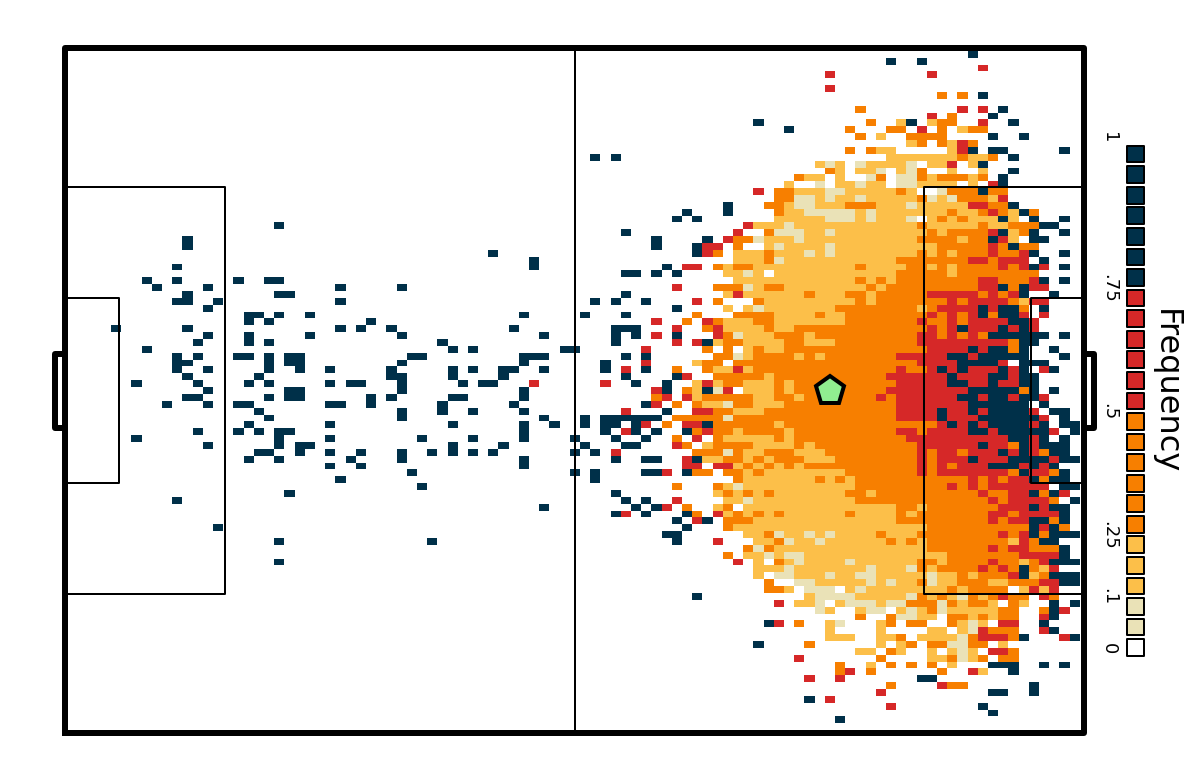

In [8]:
base_state = ['simple_pass', '0', '1', '1', '1', '20', '40', '20', '50', '0', '0']
base_state += ['simple_pass', '0', '1', '1', '1', '20', '45', '50', '50', '0', '0']
base_state += ['simple_pass', '0', '1', '1', '1', '20', '47', '75', '50', '0', '0']
draw_xg_map(base_state, model=model, k=K)
plt.plot(75, 50, marker='p', color='lightgreen', markersize=15, markeredgecolor='black', markeredgewidth=2)
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_xg_v1.pdf', bbox_inches='tight')

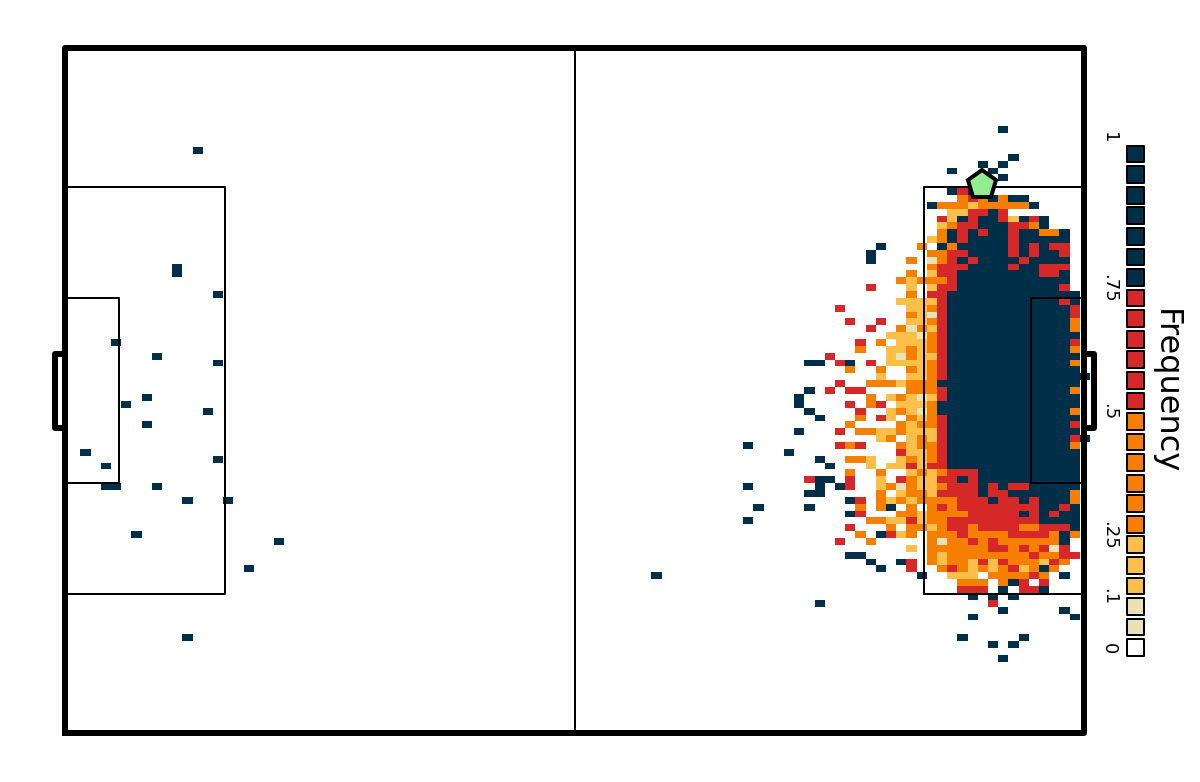

In [9]:
base_state = ['simple_pass', '0', '1', '1', '1', '20', '40', '20', '50', '0', '0']
base_state += ['simple_pass', '0', '1', '1', '1', '20', '40', '50', '50', '0', '0']
base_state += ['cross', '0', '1', '1', '1', '20', '40', '90', '80', '0', '0']
draw_xg_map(base_state, model=model, k=K)
plt.plot(90, 80, marker='p', color='lightgreen', markersize=15, markeredgecolor='black', markeredgewidth=2)
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_xg_v2.pdf', bbox_inches='tight')

# Short-term Scoring Probability

## Original

In [6]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,46,58,100,0,0,2
912060,101,0,1,0,2,47,0,90,10,0,2
912061,101,0,1,0,2,47,4,75,22,0,2


In [7]:
df_original = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_original = pd.concat([df_original[df_original.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_original.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 2.0   931.0   948.0   951.0   936.0   947.0   942.0   933.0   828.0   
    3.0    46.0    29.0    28.0    43.0    24.0    33.0    36.0   149.0   
1.0 2.0    20.0    23.0    20.0    20.0    29.0    21.0    30.0    18.0   

         912067  912068  
9   10                   
0.0 2.0     0.0     0.0  
    3.0   961.0   966.0  
1.0 2.0     0.0     0.0

## Artificial 0-0 Score

In [8]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df.loc[forecast_df[10] == 2, 10] = 0
forecast_df.loc[forecast_df[10] == 3, 10] = 1
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,46,58,100,0,0,0
912060,101,0,1,0,2,47,0,90,10,0,0
912061,101,0,1,0,2,47,4,75,22,0,0


In [9]:
df_artificial_score = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_score = pd.concat([df_artificial_score[df_artificial_score.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_score.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 0.0   942.0   948.0   940.0   950.0   954.0   957.0   948.0   849.0   
    1.0    40.0    29.0    41.0    32.0    24.0    27.0    37.0   130.0   
1.0 0.0    16.0    21.0    16.0    17.0    20.0    16.0    11.0    15.0   

         912067  912068  
9   10                   
0.0 0.0     0.0     0.0  
    1.0   963.0   959.0  
1.0 0.0     0.0     0.0

## Artificial Time remaining

In [10]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[5]] = 0
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,0,58,100,0,0,2
912060,101,0,1,0,2,0,0,90,10,0,2
912061,101,0,1,0,2,0,4,75,22,0,2


In [11]:
%%time
df_artificial_time = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_time = pd.concat([df_artificial_time[df_artificial_time.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_time.head(3)

CPU times: total: 20.7 s
Wall time: 20.1 s


912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 2.0   315.0   293.0   318.0   293.0   319.0   323.0   312.0   257.0   
    3.0   178.0   206.0   185.0   198.0   182.0   198.0   178.0   207.0   
1.0 2.0   173.0   181.0   165.0   190.0   168.0   166.0   194.0   180.0   

         912067  912068  
9   10                   
0.0 2.0     0.0     0.0  
    3.0   300.0   310.0  
1.0 2.0     0.0     0.0

# Artificial Score and Time

In [12]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[5]] = 0
forecast_df.loc[forecast_df[10] == 2, 10] = 0
forecast_df.loc[forecast_df[10] == 3, 10] = 1
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
912059,120,0,1,0,2,0,58,100,0,0,0
912060,101,0,1,0,2,0,0,90,10,0,0
912061,101,0,1,0,2,0,4,75,22,0,0


In [13]:
df_artificial_score_time = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_artificial_score_time = pd.concat([df_artificial_score_time[df_artificial_score_time.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_artificial_score_time.head(3)

912059  912060  912061  912062  912063  912064  912065  912066  \
9   10                                                                    
0.0 0.0   321.0   297.0   279.0   282.0   274.0   303.0   312.0   261.0   
    1.0   181.0   181.0   182.0   172.0   199.0   209.0   180.0   188.0   
1.0 0.0   171.0   172.0   200.0   183.0   186.0   175.0   183.0   149.0   

         912067  912068  
9   10                   
0.0 0.0     0.0     0.0  
    1.0   286.0   321.0  
1.0 0.0     0.0     0.0

# Analysis

## Realistic performance on the number of goals scored per match.

In [14]:
_df = df_artificial_score_time.copy()
_df['goals'] = _df.index.map(lambda x: x[0] + x[1])
_df['new_goals'] = _df.index.map(lambda x: x[0] + x[1])
for col in _df.columns[:-2]:
    _df[col] = _df[col] * _df['new_goals'] / _df[col].sum()
_df[_df.columns[:-2]].sum()

912059    1.132
912060    1.205
912061    1.197
912062    1.250
912063    1.223
912064    1.156
912065    1.152
912066    1.343
912067    2.169
912068    2.178
dtype: float64

## Probabilities within scenarios

In [15]:
def calculate_probability_away_win(df):
    _df = df.copy()
    _df['wins'] = _df.index.map(lambda x: x[0] < x[1])
    _df['draws'] = _df.index.map(lambda x: x[0] == x[1])

    points = []
    for col in _df.columns[:-2]:
        points.append(((_df[col] * _df['wins']).sum() * 3 + (_df[col] * _df['draws']).sum()) / _df[col].sum())
    
    return points

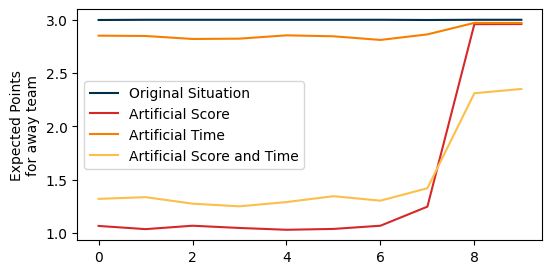

In [19]:
plt.rcParams['figure.figsize'] = (6, 3)
plt.plot(calculate_probability_away_win(df_original), label='Original Situation', color=COLORS[-1])
plt.plot(calculate_probability_away_win(df_artificial_score), label='Artificial Score', color=COLORS[-2])
plt.plot(calculate_probability_away_win(df_artificial_time), label='Artificial Time', color=COLORS[-3])
plt.plot(calculate_probability_away_win(df_artificial_score_time), label='Artificial Score and Time', color=COLORS[-4])
plt.ylabel('Expected Points\nfor away team')
plt.xlabel('Event Number')
plt.legend();
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_points_sequence.pdf')

## Simulating full game

In [20]:
forecast_df = df.loc[910375:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
910375,101,0,1,0,1,0,5,49,50,0,0
910376,101,0,1,0,1,0,6,38,57,0,0
910377,101,0,1,0,1,0,9,28,35,0,0


In [21]:
%%time
df_full = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=100)
df_full = pd.concat([df_full[df_full.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_full.head(3)

CPU times: total: 4min 6s
Wall time: 4min 6s


910375  910376  910377  910378  910379  910380  910381  910382  \
9   10                                                                    
0.0 1.0    18.0     7.0    10.0     8.0     5.0    13.0    11.0    12.0   
1.0 0.0    13.0    14.0    11.0    10.0    10.0     8.0     9.0    13.0   
    1.0    11.0    11.0    11.0    16.0    11.0    16.0    12.0    16.0   

         910383  910384  ...  912059  912060  912061  912062  912063  912064  \
9   10                   ...                                                   
0.0 1.0    12.0    12.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1.0 0.0    13.0     7.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
    1.0    18.0    16.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

         912065  912066  912067  912068  
9   10                                   
0.0 1.0     0.0     0.0     0.0     0.0  
1.0 0.0     0.0     0.0     0.0     0.0  
    1.0     0.0     0.0     0.0     0.0  

[3 rows x 1694 columns]

## What if analysis - betting scenario

In [22]:
forecast_df = df.loc[910375:912067].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df = forecast_df[(forecast_df[4] == 2)]
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
911239,101,0,1,1,2,0,1,51,48,0,0
911240,101,0,1,1,2,0,3,45,50,0,0
911241,101,0,1,1,2,0,6,30,31,0,0


In [23]:
df_wia = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=100)
df_wia = pd.concat([df_wia[df_wia.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_wia.head(3)

911239  911240  911241  911242  911243  911244  911245  911246  \
9   10                                                                    
0.0 1.0    23.0    16.0    13.0    19.0    17.0    18.0    18.0    21.0   
    0.0    22.0    29.0    34.0    28.0    36.0    30.0    32.0    32.0   
1.0 0.0    14.0    18.0    21.0    12.0    11.0    15.0    19.0    13.0   

         911247  911248  ...  912058  912059  912060  912061  912062  912063  \
9   10                   ...                                                   
0.0 1.0    26.0    24.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
    0.0    28.0    34.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1.0 0.0    14.0    17.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

         912064  912065  912066  912067  
9   10                                   
0.0 1.0     0.0     0.0     0.0     0.0  
    0.0     0.0     0.0     0.0     0.0  
1.0 0.0     0.0     0.0     0.0     0.0  

[3 rows x 829 columns]

In [24]:
def calculate_event_to_end_probabilities(df):
    _df = df.copy()
    _df['h_wins'] = _df.index.map(lambda x: x[0] > x[1])
    _df['draws'] = _df.index.map(lambda x: x[0] == x[1])
    _df['a_wins'] = _df.index.map(lambda x: x[0] < x[1])
    _df['over_2_5'] = _df.index.map(lambda x: (x[0] + x[1]) > 2.5)
    _df['under_2_5'] = _df.index.map(lambda x: (x[0] + x[1]) <= 2.5)

    h_wins = []
    draws = []
    a_wins = []
    over_2_5 = []
    under_2_5 = []
    for col in _df.columns[:-2]:
        h_wins.append((_df[col] * _df['h_wins']).sum() / _df[col].sum())
        draws.append((_df[col] * _df['draws']).sum() / _df[col].sum())
        a_wins.append((_df[col] * _df['a_wins']).sum() / _df[col].sum())
        over_2_5.append((_df[col] * _df['over_2_5']).sum() / _df[col].sum())
        under_2_5.append((_df[col] * _df['under_2_5']).sum() / _df[col].sum())
    
    return h_wins, draws, a_wins, over_2_5, under_2_5

CPU times: total: 641 ms
Wall time: 615 ms


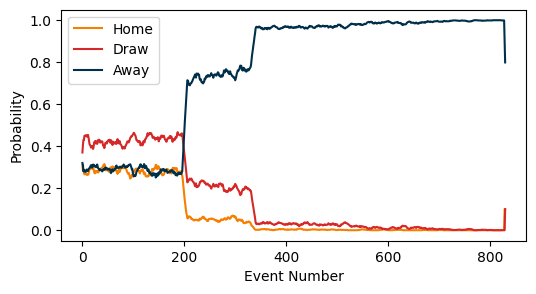

In [26]:
%%time
plt.rcParams['figure.figsize'] = (6, 3)
h_wins, draws, a_wins, _, _ = calculate_event_to_end_probabilities(df_wia)
plt.plot(pd.Series(h_wins).rolling(10, min_periods=1).mean()[:-1], label='Home', color=COLORS[-3])
plt.plot(pd.Series(draws).rolling(10, min_periods=1).mean()[:-1], label='Draw', color=COLORS[-2])
plt.plot(pd.Series(a_wins).rolling(10, min_periods=1).mean()[:-1], label='Away', color=COLORS[-1])
plt.legend();
plt.ylabel('Probability')
plt.xlabel('Event Number')
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_wia_sequence.pdf')

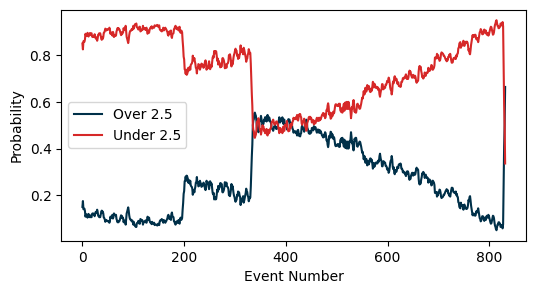

In [28]:
plt.rcParams['figure.figsize'] = (6, 3)
_, _, _, over, under = calculate_event_to_end_probabilities(df_wia)
plt.plot(pd.Series(over).rolling(5, min_periods=1).mean(), label='Over 2.5', color=COLORS[-1])
plt.plot(pd.Series(under).rolling(5, min_periods=1).mean(), label='Under 2.5', color=COLORS[-2])
plt.legend();
plt.ylabel('Probability')
plt.xlabel('Event Number')
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_over_under_sequence.pdf')

## Short term scoring chance

In [8]:
forecast_df = df.loc[910375:912067].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df = forecast_df[(forecast_df[4] == 2)]
forecast_df[[i for i in range(11)]].head(3)

,0,1,2,3,4,5,6,7,8,9,10
911239,101,0,1,1,2,0,1,51,48,0,0
911240,101,0,1,1,2,0,3,45,50,0,0
911241,101,0,1,1,2,0,6,30,31,0,0


In [9]:
df_la10 = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=10, n_sims_per_row=N_SIMS)
df_la10 = pd.concat([df_la10[df_la10.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)
df_la10.head(3)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
momentum_h_scoring = []
momentum_a_scoring = []
for i in forecast_df.index:
    current_h_score = forecast_df.loc[i][9]
    current_a_score = forecast_df.loc[i][10]

    momentum_h_scoring.append(df_la10[i].loc[current_h_score+1, current_a_score])
    momentum_a_scoring.append(df_la10[i].loc[current_h_score, current_a_score+1])
    #print(i, current_h_score, current_a_score, df_la10[i].loc[current_h_score, current_a_score], , df_la10[i].loc[current_h_score, current_a_score+1])

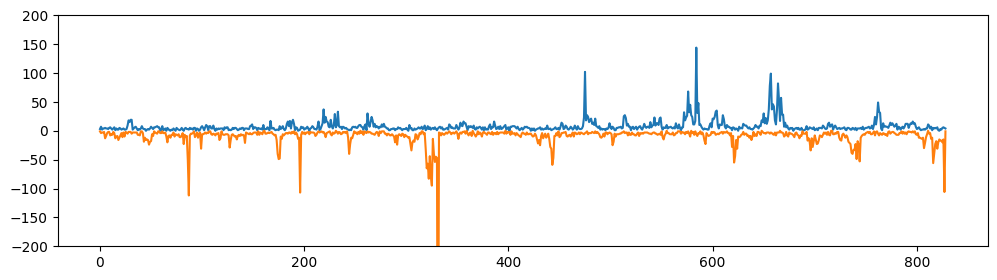

In [33]:
plt.rcParams['figure.figsize'] = (12, 3)
plt.plot(np.array(momentum_h_scoring))
plt.plot(-np.array(momentum_a_scoring))
plt.ylim([-200, 200]);

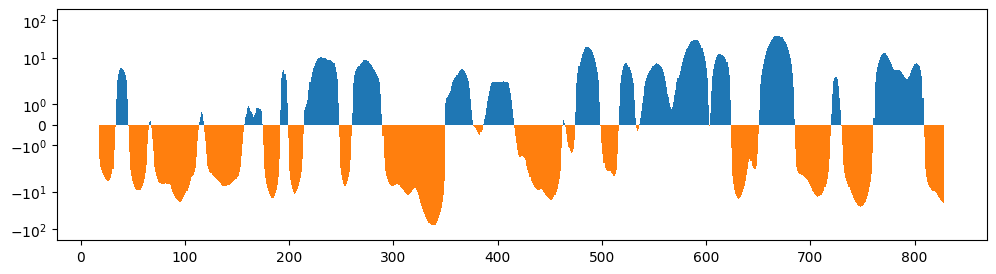

In [34]:
rolling_diff = pd.Series(np.array(momentum_h_scoring)).rolling(10).mean().rolling(10).mean() - pd.Series(np.array(momentum_a_scoring)).rolling(10).mean().rolling(10).mean()
plt.rcParams['figure.figsize'] = (12, 3)
colors = ['C1' if value < 0 else 'C0' for value in rolling_diff]
plt.bar(range(len(rolling_diff)), rolling_diff, color=colors, width=1)
plt.yscale('symlog')
plt.ylim([-200, 200]);

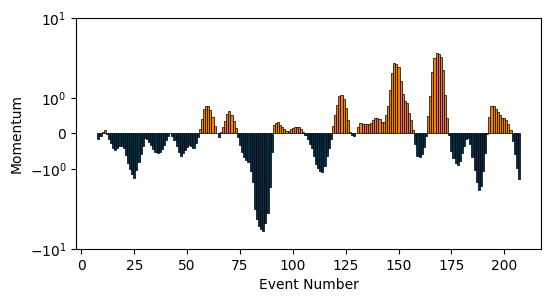

In [47]:
rolling_diff = pd.Series(np.array(momentum_h_scoring)) - pd.Series(np.array(momentum_a_scoring))
rolling_diff_grouped = rolling_diff.groupby(rolling_diff.index // 4).mean().rolling(5).mean().rolling(5).mean() /10
plt.rcParams['figure.figsize'] = (6, 3)
colors_grouped = [COLORS[-1] if value < 0 else COLORS[-3] for value in rolling_diff_grouped]
plt.bar(range(len(rolling_diff_grouped)), rolling_diff_grouped, color=colors_grouped, width=1, edgecolor='black', linewidth=0.5)
plt.yscale('symlog')
plt.ylim([-10, 10]);
plt.ylabel('Momentum')
plt.xlabel('Event Number')
plt.savefig(f'figures/paper_sigkdd/{MODEL_NAME}_momentum_sequence.pdf');

# VAEP metrics

# Long-term probabilities

In [45]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
df_lt_inf = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_lt_inf = pd.concat([df_lt_inf[df_lt_inf.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)

In [46]:
xpts_lt_inf_home = []
xpts_lt_inf_away = []
df_lt_inf['home_points'] = df_lt_inf.index.map(lambda x: (x[0] > x[1]) * 3 + (x[0] == x[1]))
df_lt_inf['away_points'] = df_lt_inf.index.map(lambda x: (x[0] < x[1]) * 3 + (x[0] == x[1]))
for col in df_lt_inf.columns[:-2]:
    xpts_lt_inf_home.append((df_lt_inf[col] * df_lt_inf['home_points']).sum() / df_lt_inf[col].sum())
    xpts_lt_inf_away.append((df_lt_inf[col] * df_lt_inf['away_points']).sum() / df_lt_inf[col].sum())
forecast_df['xpts_lt_inf_home'] = xpts_lt_inf_home
forecast_df['xpts_lt_inf_away'] = xpts_lt_inf_away
forecast_df['vaep_lt_inf'] = (forecast_df['xpts_lt_inf_home'] - forecast_df['xpts_lt_inf_home'].shift(1)) * forecast_df[3] + (forecast_df['xpts_lt_inf_away'] - forecast_df['xpts_lt_inf_away'].shift(1)) * (1 - forecast_df[3])
forecast_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,xpts_lt_inf_home,xpts_lt_inf_away,vaep_lt_inf
912059,120,0,1,0,2,46,58,100,0,0,...,139,139,139,139,139,139,139,0.001,2.998,NaN
912060,101,0,1,0,2,47,0,90,10,0,...,139,139,139,139,139,139,139,0.001,2.998,0.000
912061,101,0,1,0,2,47,4,75,22,0,...,139,139,139,139,139,139,139,0.002,2.996,-0.002
912062,101,0,1,0,2,47,6,86,4,0,...,139,139,139,139,139,139,139,0.001,2.998,0.002
912063,101,0,1,0,2,47,8,69,30,0,...,139,139,139,139,139,139,139,0.000,3.000,0.002
912064,102,0,1,0,2,47,11,93,14,0,...,139,139,139,139,139,139,139,0.000,3.000,0.000
912065,103,0,0,1,2,47,11,7,86,0,...,139,139,139,139,139,139,139,0.001,2.998,0.001
912066,101,0,1,0,2,47,12,97,36,0,...,139,139,139,139,139,139,139,0.000,3.000,0.002
912067,116,1,1,0,2,47,14,87,43,0,...,139,139,139,139,139,139,139,0.000,3.000,0.000
912068,122,1,0,1,2,47,17,0,100,0,...,139,139,139,139,139,139,139,0.000,3.000,0.000


# Long-term probabilities (hypothetical 0-0 score)

In [51]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
forecast_df.loc[forecast_df[10] == 2, 10] = 0
forecast_df.loc[forecast_df[10] == 3, 10] = 1
df_lt_inf = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=2000, n_sims_per_row=1000)
df_lt_inf = pd.concat([df_lt_inf[df_lt_inf.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)

In [52]:
xpts_lt_inf_home = []
xpts_lt_inf_away = []
df_lt_inf['home_points'] = df_lt_inf.index.map(lambda x: (x[0] > x[1]) * 3 + (x[0] == x[1]))
df_lt_inf['away_points'] = df_lt_inf.index.map(lambda x: (x[0] < x[1]) * 3 + (x[0] == x[1]))
for col in df_lt_inf.columns[:-2]:
    xpts_lt_inf_home.append((df_lt_inf[col] * df_lt_inf['home_points']).sum() / df_lt_inf[col].sum())
    xpts_lt_inf_away.append((df_lt_inf[col] * df_lt_inf['away_points']).sum() / df_lt_inf[col].sum())
forecast_df['xpts_lt_inf_home'] = xpts_lt_inf_home
forecast_df['xpts_lt_inf_away'] = xpts_lt_inf_away
forecast_df['vaep_lt_inf'] = (forecast_df['xpts_lt_inf_home'] - forecast_df['xpts_lt_inf_home'].shift(1)) * forecast_df[3] + (forecast_df['xpts_lt_inf_away'] - forecast_df['xpts_lt_inf_away'].shift(1)) * (1 - forecast_df[3])
forecast_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,xpts_lt_inf_home,xpts_lt_inf_away,vaep_lt_inf
912059,120,0,1,0,2,46,58,100,0,0,...,139,139,139,139,139,139,139,0.991,1.072,NaN
912060,101,0,1,0,2,47,0,90,10,0,...,139,139,139,139,139,139,139,0.989,1.076,0.004
912061,101,0,1,0,2,47,4,75,22,0,...,139,139,139,139,139,139,139,0.995,1.052,-0.024
912062,101,0,1,0,2,47,6,86,4,0,...,139,139,139,139,139,139,139,1.001,1.037,-0.015
912063,101,0,1,0,2,47,8,69,30,0,...,139,139,139,139,139,139,139,1.015,1.039,0.002
912064,102,0,1,0,2,47,11,93,14,0,...,139,139,139,139,139,139,139,1.004,1.052,0.013
912065,103,0,0,1,2,47,11,7,86,0,...,139,139,139,139,139,139,139,0.992,1.064,-0.012
912066,101,0,1,0,2,47,12,97,36,0,...,139,139,139,139,139,139,139,0.924,1.233,0.169
912067,116,1,1,0,2,47,14,87,43,0,...,139,139,139,139,139,139,139,0.023,2.954,1.721
912068,122,1,0,1,2,47,17,0,100,0,...,139,139,139,139,139,139,139,0.022,2.956,-0.001


## Short-term probabilities on short horizon

In [47]:
forecast_df = df.loc[912059:912068].copy()
for i in range(11, 18):
    forecast_df[i] = '<NaN>'
for i in range(0, 18):
    forecast_df[i] = forecast_df[i].map(tokenizer_map)
df_st_sh = simulate_from_dataframe(forecast_df, model, model_k=K, max_events=10, n_sims_per_row=N_SIMS)
df_st_sh = pd.concat([df_st_sh[df_st_sh.index == i][[9, 10]].value_counts().rename(i) for i in forecast_df.index], axis=1).fillna(0)

In [48]:
momentum_h_scoring = []
momentum_a_scoring = []
for i in forecast_df.index:
    current_h_score = forecast_df.loc[i][9]
    current_a_score = forecast_df.loc[i][10]

    momentum_h_scoring.append(df_st_sh[i].loc[current_h_score+1, current_a_score] / N_SIMS)
    momentum_a_scoring.append(df_st_sh[i].loc[current_h_score, current_a_score+1] / N_SIMS)
    #print(i, current_h_score, current_a_score, df_la10[i].loc[current_h_score, current_a_score], , df_la10[i].loc[current_h_score, current_a_score+1])
forecast_df['prob_h_scoring'] = momentum_h_scoring
forecast_df['prob_a_scoring'] = momentum_a_scoring
forecast_df['vaep_st_sh'] = (forecast_df['prob_h_scoring'].diff() - forecast_df['prob_a_scoring'].diff()) * forecast_df[3] + (forecast_df['prob_a_scoring'].diff() - forecast_df['prob_h_scoring'].diff()) * (1 - forecast_df[3])
forecast_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,prob_h_scoring,prob_a_scoring,vaep_st_sh
912059,120,0,1,0,2,46,58,100,0,0,...,139,139,139,139,139,139,139,0.004,0.029,NaN
912060,101,0,1,0,2,47,0,90,10,0,...,139,139,139,139,139,139,139,0.003,0.019,-0.009
912061,101,0,1,0,2,47,4,75,22,0,...,139,139,139,139,139,139,139,0.002,0.017,-0.001
912062,101,0,1,0,2,47,6,86,4,0,...,139,139,139,139,139,139,139,0.001,0.019,0.003
912063,101,0,1,0,2,47,8,69,30,0,...,139,139,139,139,139,139,139,0.005,0.017,-0.006
912064,102,0,1,0,2,47,11,93,14,0,...,139,139,139,139,139,139,139,0.005,0.019,0.002
912065,103,0,0,1,2,47,11,7,86,0,...,139,139,139,139,139,139,139,0.005,0.021,-0.002
912066,101,0,1,0,2,47,12,97,36,0,...,139,139,139,139,139,139,139,0.003,0.112,0.093
912067,116,1,1,0,2,47,14,87,43,0,...,139,139,139,139,139,139,139,0.005,0.004,-0.110
912068,122,1,0,1,2,47,17,0,100,0,...,139,139,139,139,139,139,139,0.004,0.006,-0.003
